In [1]:
import os

# Define the data path
data_path = 'Data-gesture'

# Check if the directory exists and delete it
if os.path.exists(data_path):
    os.system(f'rm -rf {data_path}')

# Clone the GitHub repository
os.system('git clone https://github.com/Thienvp/Data-gesture')

# pip install rembg

Cloning into 'Data-gesture'...


0

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm
import cv2
import sklearn
import skimage
import random

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib
# from rembg import remove
import seaborn as sns
sns.set()
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy.stats import uniform  # Import uniform
from sklearn.base import BaseEstimator, TransformerMixin

2024-06-15 17:53:19.265423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 17:53:19.265565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 17:53:19.395436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
np.random.seed(42)
class Loaddata():
    def __init__(self,path,image_size):
        self.path=path
        self.x = []
        self.y =  []
        image_width, image_height=image_size
        for folderName in os.listdir(self.path):
            if(folderName=='create_data.py'):
                continue
            if not folderName.startswith("."):
                if folderName in ["left"]:
                    label = 0
                elif folderName in ["right"]:
                    label = 1
                elif folderName in ["up"]:
                    label = 2
                else:
                    continue
                for image_filename in tqdm(os.listdir(self.path +"/" +folderName+"/")):
                    image = cv2.imread(self.path + "/" +folderName + "/" + image_filename)
                    image = cv2.resize(image, dsize=(image_width, image_height))
                    if image is not None:
                        img_arr = np.asarray(image)
#                         img_arr=remove_background(img_arr)
                        self.x.append(img_arr)
                        self.y.append(label)

        self.x=np.array(self.x)
        self.y=np.array(self.y)
        # Image Normalization
        self.x=self.x/255.0

        indices = np.arange(self.x.shape[0])
        np.random.shuffle(indices)
        self.x = self.x[indices]
        self.y = self.y[indices]

    def load(self):

        return self.x,self.y

    def saveArrayImage(self,path,is_train=True):
        if is_train:
            np.save(path+"/x_train.npy",self.x)
            np.save(path+"/y_train.npy",self.y)
        else:
            np.save(path+"/x_test.npy",self.x)
            np.save(path+"/y_test.npy",self.y)

    def loadArrayImage(self,path,is_train=True):
        if is_train:
            self.x = np.load(path+"/x_train.npy")
            self.y = np.load(path+"/y_train.npy")
        else:
            self.x = np.load(path+"/x_test.npy")
            self.y = np.load(path+"/y_test.npy")
        return  self.x,self.y



In [4]:
train_path = "/kaggle/working/Data-gesture/data"
test_path = '/kaggle/working/Data-gesture/test'
img_size = (224, 224)
labels=["left","right","up"]

In [5]:
train_loader = Loaddata(train_path, img_size)
test_loader = Loaddata(test_path, img_size)

100%|██████████| 100/100 [00:00<00:00, 1213.21it/s]


In [6]:
X_train,y_train= train_loader.load()
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_test, y_test = test_loader.load()

In [7]:
print(len(y_train))
print(len(y_test))
# print(len(y_valid))

2250
300


In [8]:
def draw_confusion_matrix(y_true,y_pred):
  cm = confusion_matrix(y_true, y_pred)
  # labels = [f'Class {i}' for i in range(len(cm))]
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

In [9]:
# @title Feature Extractor : VGG16 - pretrain ImageNet (224x224x3)
class VGGFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Loading VGG16 excluding fully connected layers
        IMG_SHAPE = (img_size[0], img_size[1], 3)
#         vgg16_weight_path = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        vgg16_model = VGG16(
            weights='imagenet',
            include_top=False, # whether to include the 3 fully-connected layers at the top of the network.
            input_shape=IMG_SHAPE
        )
        self.vgg_feature_extractor = Sequential()
        self.vgg_feature_extractor.add(vgg16_model)
        self.vgg_feature_extractor.add(Flatten())
        self.vgg_feature_extractor.layers[0].trainable = False
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features=self.vgg_feature_extractor.predict(X)
        return np.array(features)

# Linear

In [10]:
vgg = VGGFeatureExtractor()
X_train = vgg.transform(X_train)
len(X_train)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


2024-06-15 17:53:45.117668: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-06-15 17:53:45.117726: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-06-15 17:53:45.117740: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-06-15 17:53:45.117753: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-06-15 17:53:45.117773: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-06-15 17:53:45.117784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-06-15 17:53:45.117794: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-06-15 17:53:45.117805: E external/local_xla/xla/se

 4/71 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step

I0000 00:00:1718474040.318455      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

2024-06-15 17:54:04.800223: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.17844, expected 3.56217
2024-06-15 17:54:04.800288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.52289, expected 2.90662
2024-06-15 17:54:04.800298: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.66917, expected 4.05289
2024-06-15 17:54:04.800306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.67338, expected 4.0571
2024-06-15 17:54:04.800314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.6813, expected 4.06503
2024-06-15 17:54:04.800321: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.79963, expected 4.18336
2024-06-15 17:54:04.800329: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 4.73133, expected 4.11506
2024-06-15 17:54:04.800337: E external/local_xla/xl

71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step


2250

In [11]:
Image_test = X_test
X_test = vgg.transform(X_test)
X_test.shape

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

2024-06-15 17:54:12.376686: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.37359, expected 2.7841
2024-06-15 17:54:12.376759: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.43935, expected 3.84986
2024-06-15 17:54:12.376768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.60416, expected 4.01467
2024-06-15 17:54:12.376776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.68174, expected 4.09225
2024-06-15 17:54:12.376784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.80871, expected 4.21922
2024-06-15 17:54:12.376792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.51692, expected 3.92744
2024-06-15 17:54:12.376799: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.75989, expected 4.1704
2024-06-15 17:54:12.376807: E external/local_xla/xla/serv

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 859ms/step


(300, 25088)

In [12]:
def show_incorrect_predictions(Image_test, y_test, y_pred, num_cols=4):
    incorrect_indices = np.where(y_test != y_pred)[0]
    num_incorrect = len(incorrect_indices)
    
    num_rows = (num_incorrect + num_cols - 1) // num_cols  # Tính số hàng cần thiết
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    for ax in axes[num_incorrect:]:
        ax.axis('off')
    
    for idx, incorrect_idx in enumerate(incorrect_indices):
        ax = axes[idx]
        image = Image_test[incorrect_idx]
        
        # Nếu X_test là ảnh, chúng ta cần reshape và chuyển đổi nó về đúng định dạng
        if len(image.shape) == 1:  # Nếu ảnh bị flatten, cần reshape lại
            image = image.reshape((28, 28))  # Giả sử ảnh kích thước 28x28, thay đổi nếu cần

        ax.imshow(image, cmap='gray')  # Nếu ảnh là grayscale
        pred = y_pred[incorrect_idx]
        true = y_test[incorrect_idx]
        ax.set_title(f"Predict: {pred} - True: {true}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 100, 'gamma': 'auto', 'kernel': 'sigmoid'}


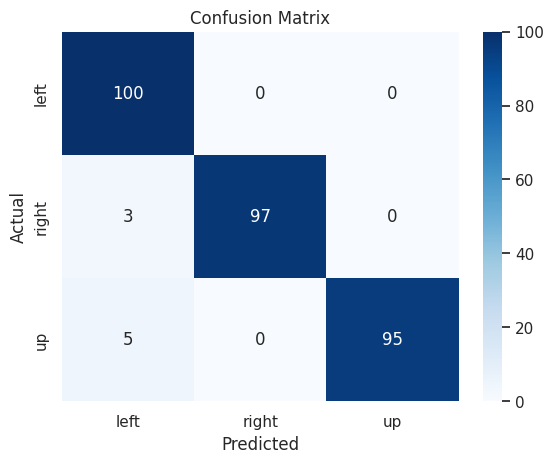

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       100
           1       1.00      0.97      0.98       100
           2       1.00      0.95      0.97       100

    accuracy                           0.97       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.97      0.97       300



In [13]:
param_grid = {'C': [0.1, 1, 10, 100,1000],  
              'gamma': ["scale", "auto"], 
              'kernel': ['sigmoid']}  
sigmoid = GridSearchCV( SVC(), param_grid, verbose = 1) 
  
# fitting the model for grid search 
sigmoid.fit(X_train, y_train) 
print(sigmoid.best_params_) 
y_pred = sigmoid.best_estimator_.predict(X_test)
draw_confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


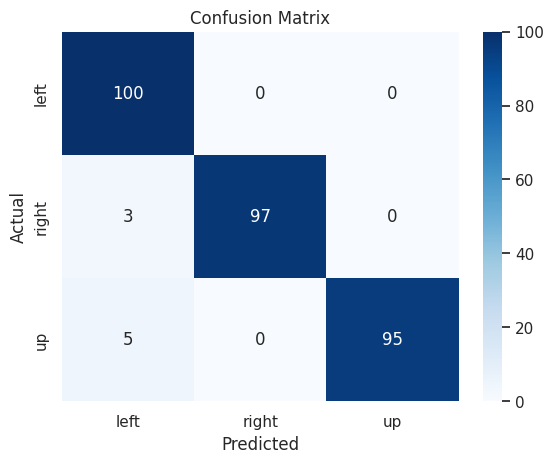

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       100
           1       1.00      0.97      0.98       100
           2       1.00      0.95      0.97       100

    accuracy                           0.97       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.97      0.97       300



In [14]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': ["scale", "auto"], 
              'kernel': ['linear']}  
linear = GridSearchCV( SVC(), param_grid, verbose = 1) 
  
# fitting the model for grid search 
linear.fit(X_train, y_train) 
print(linear.best_params_) 
y_pred = linear.best_estimator_.predict(X_test)
draw_confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


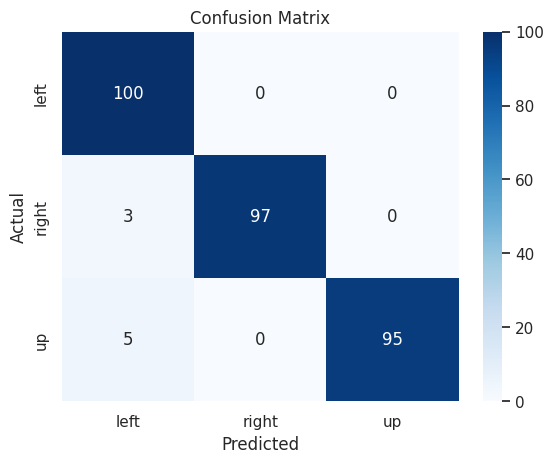

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       100
           1       1.00      0.97      0.98       100
           2       1.00      0.95      0.97       100

    accuracy                           0.97       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.97      0.97       300



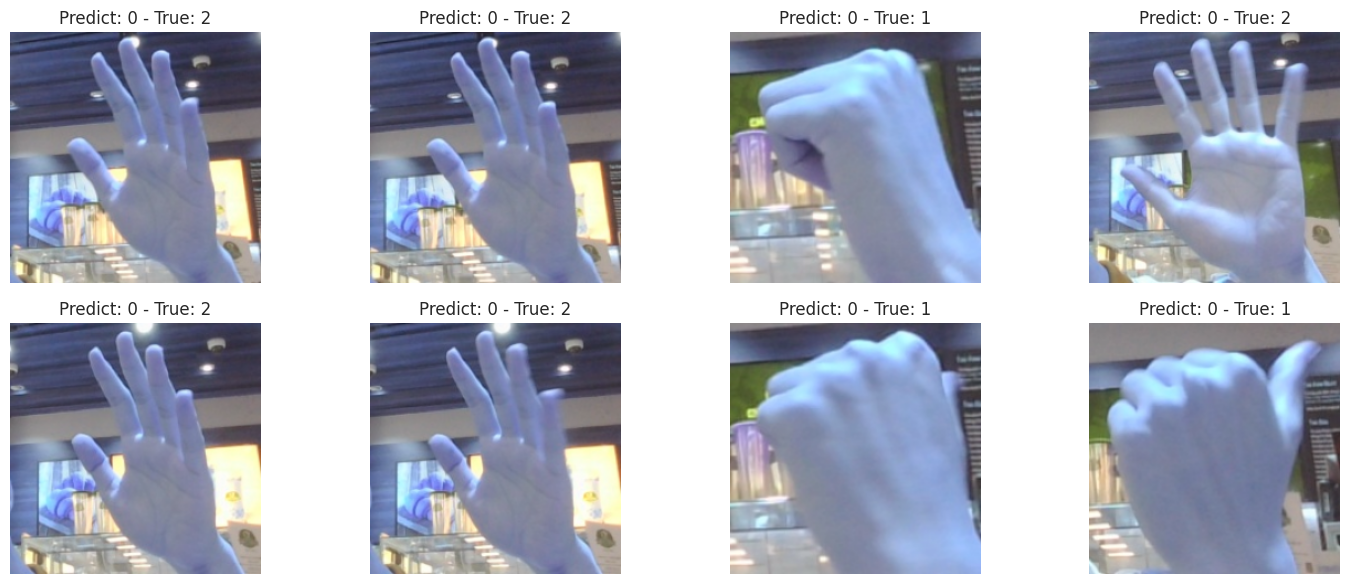

In [15]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': ["scale", "auto"], 
              'kernel': ['rbf']}  
rbf = GridSearchCV(SVC(), param_grid, verbose = 1) 
  
# fitting the model for grid search 
rbf.fit(X_train, y_train) 
print(rbf.best_params_) 
y_pred = rbf.best_estimator_.predict(X_test)
draw_confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))
show_incorrect_predictions(Image_test, y_test, y_pred, num_cols=4)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 1000, 'gamma': 'auto', 'kernel': 'poly'}


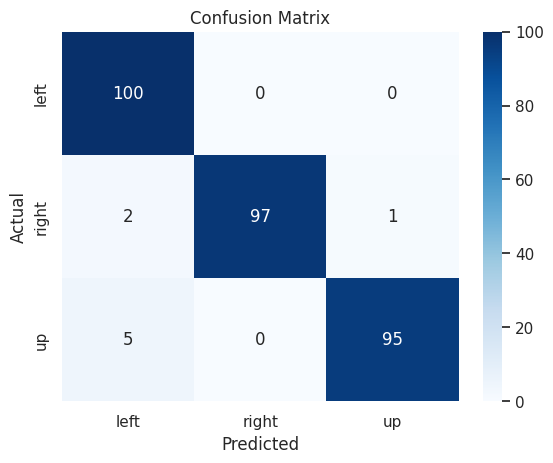

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       100
           1       1.00      0.97      0.98       100
           2       0.99      0.95      0.97       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



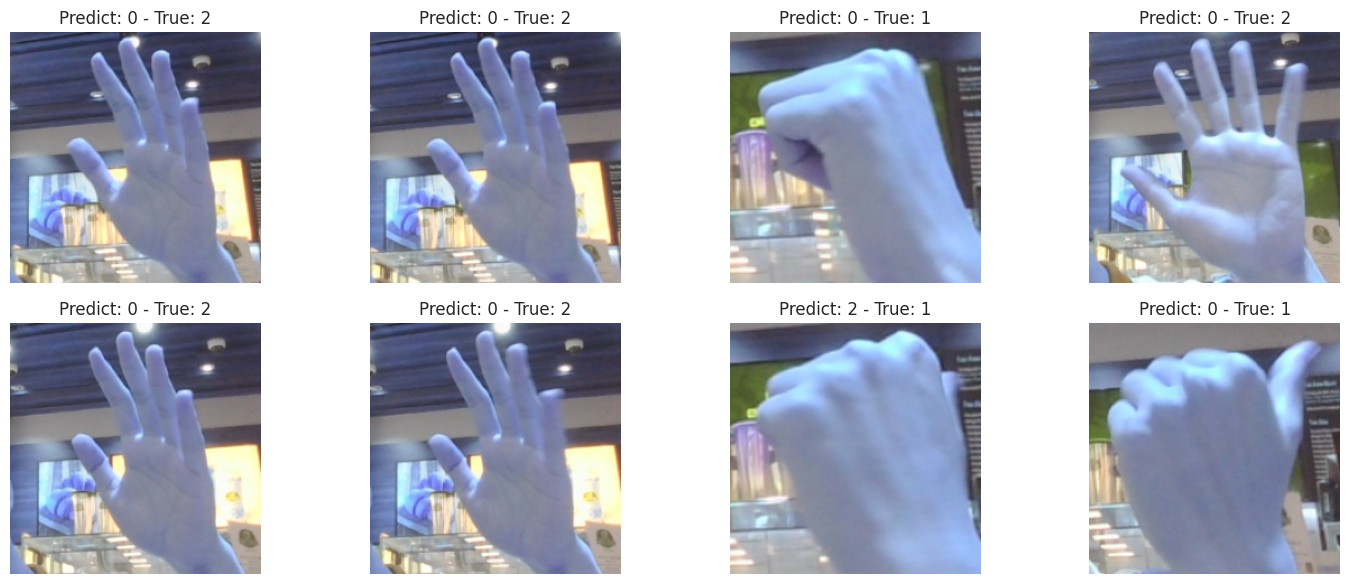

In [16]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': ["scale", "auto"], 
              'kernel': ['poly']}  
poly = GridSearchCV(SVC(), param_grid, verbose = 1) 
  
# fitting the model for grid search 
poly.fit(X_train, y_train) 
print(poly.best_params_) 
y_pred = poly.best_estimator_.predict(X_test)
draw_confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))
show_incorrect_predictions(Image_test, y_test, y_pred, num_cols=4)